# Traduzioni orientate ai dati

In [ ]:
from urllib.request import urlopen
from IPython.display import HTML

from liblet import ANTLR, Tree, Stack, warn

## Da JSON a tabella HTML

In [ ]:
# usiamo una grammatica "pronta"

with urlopen('https://raw.githubusercontent.com/antlr/grammars-v4/master/json/JSON.g4') as inf:
    grammar = inf.read().decode('utf-8')

JSON = ANTLR(grammar)

In [ ]:
JSON.print_grammar()

  1:	
  2:	/** Taken from "The Definitive ANTLR 4 Reference" by Terence Parr */
  3:	
  4:	// Derived from http://json.org
  5:	grammar JSON;
  6:	
  7:	json
  8:	   : value
  9:	   ;
 10:	
 11:	obj
 12:	   : '{' pair (',' pair)* '}'
 13:	   | '{' '}'
 14:	   ;
 15:	
 16:	pair
 17:	   : STRING ':' value
 18:	   ;
 19:	
 20:	arr
 21:	   : '[' value (',' value)* ']'
 22:	   | '[' ']'
 23:	   ;
 24:	
 25:	value
 26:	   : STRING
 27:	   | NUMBER
 28:	   | obj
 29:	   | arr
 30:	   | 'true'
 31:	   | 'false'
 32:	   | 'null'
 33:	   ;
 34:	
 35:	
 36:	STRING
 37:	   : '"' (ESC | SAFECODEPOINT)* '"'
 38:	   ;
 39:	
 40:	
 41:	fragment ESC
 42:	   : '\\' (["\\/bfnrt] | UNICODE)
 43:	   ;
 44:	
 45:	
 46:	fragment UNICODE
 47:	   : 'u' HEX HEX HEX HEX
 48:	   ;
 49:	
 50:	
 51:	fragment HEX
 52:	   : [0-9a-fA-F]
 53:	   ;
 54:	
 55:	
 56:	fragment SAFECODEPOINT
 57:	   : ~ ["\\\u0000-\u001F]
 58:	   ;
 59:	
 60:	
 61:	NUMBER
 62:	   : '-'? INT ('.' [0-9] +)? EXP?
 63:	   ;
 64:	
 65:	
 66:	fra

### L'albero di parsing (con ANTLR)

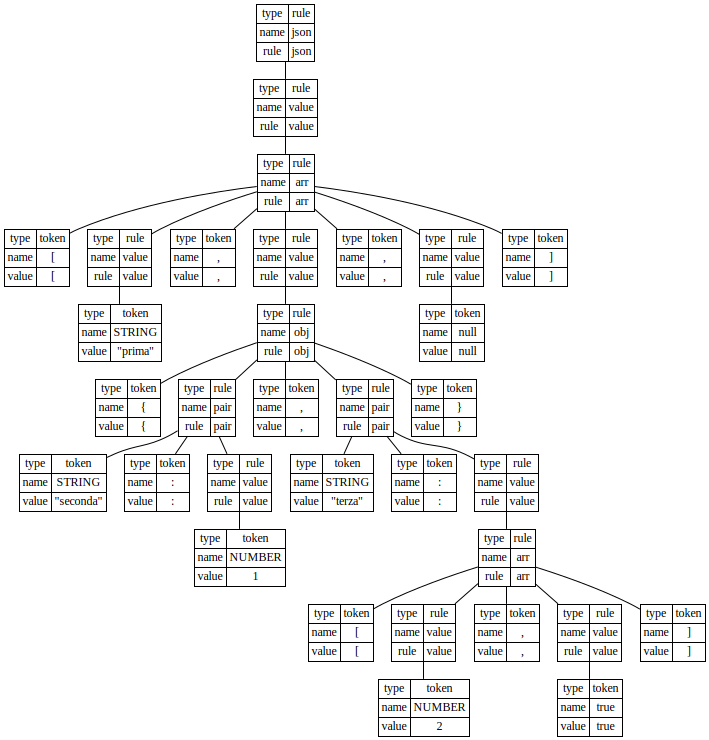

In [ ]:
json_source = """
[   "prima",
    {
        "seconda": 1, 
        "terza": [2, true]
    },
    null
]
"""
parse_tree = JSON.tree(json_source, 'json')
parse_tree

### Costruzione dell'AST con *dispatch table*

In [ ]:
# dapprima in modo incrementale… 

def to_ast(tree):
    name = tree.root['name']
    if name in DISPATCH_TABLE: return DISPATCH_TABLE[name](tree)
    # caso "cath call"
    ast_children = [to_ast(child) for child in tree.children] if tree.children else None
    return Tree({'type': '<UNDEF>', 'name': tree.root['name']}, ast_children)

In [ ]:
# … aggiungendo man mano codice alla dispatch table

def STRING(tree):
    return Tree({'type': 'string', 'value': tree.root['value'][1:-1]})

def NUMBER(tree):
    return Tree({'type': 'number', 'value': tree.root['value']})

DISPATCH_TABLE = {
    'STRING': STRING,
    'NUMBER': NUMBER
}

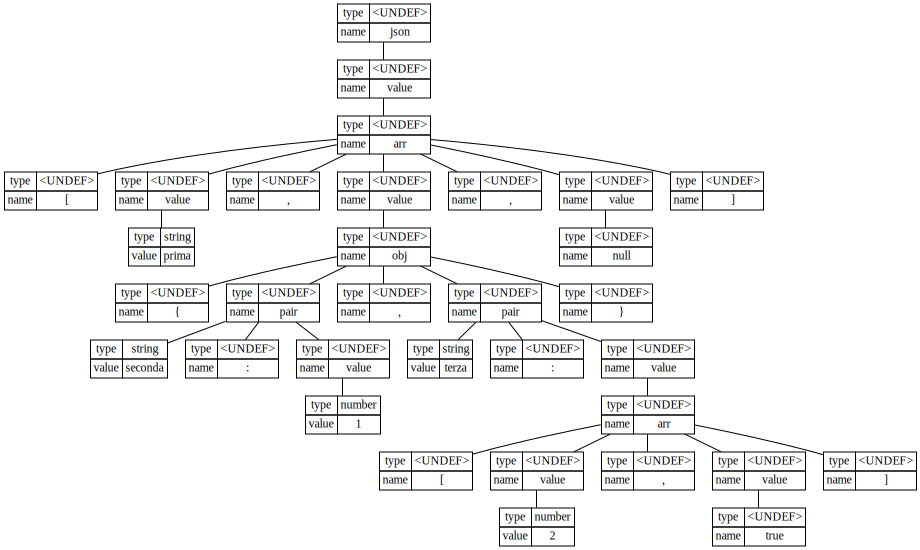

In [ ]:
to_ast(parse_tree)

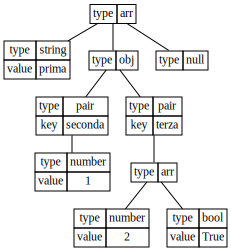

In [ ]:
# tutto assieme

def STRING(tree):
    return Tree({'type': 'string', 'value': tree.root['value'][1:-1]})

def NUMBER(tree):
    return Tree({'type': 'number', 'value': tree.root['value']})

def null(tree):
    return Tree({'type': 'null'})

def boolean(tree):
    return Tree({'type': 'bool', 'value': True if tree.root['name'] == 'true' else False})

def value(tree):
    child = tree.children[0]
    return json_ast(child)

def arr(tree):
    values = tree.children[1::2] 
    return Tree({'type': 'arr'}, [json_ast(tree) for tree in values])

def pair(tree):
    name, _, value = tree.children
    return Tree({'type': 'pair', 'key': name.root['value'][1:-1]}, [json_ast(tree.children[2])])    

def obj(tree):
    pairs = tree.children[1::2]
    return Tree({'type': 'obj'}, [json_ast(tree) for tree in pairs])

def json(tree):
    return json_ast(tree.children[0])

JSON_DISPATCH_TABLE = {
    'null': null,
    'STRING': STRING,
    'NUMBER': NUMBER,
    'true': boolean,
    'false': boolean,
    'value': value,
    'arr': arr,
    'pair': pair,
    'obj': obj,
    'json': json
}

def json_ast(tree):
    return JSON_DISPATCH_TABLE[tree.root['name']](tree)

ast = json_ast(parse_tree)
ast

### Dall'AST alla tabella HTML

Usando la pila delle chiamate ricorsive.

In [ ]:
def ast2html(tree):
    node_type = tree.root['type']
    if node_type == 'bool':
        return '☑' if tree.root['value'] else '☐'
    elif node_type == 'null':
        return '␀'
    elif node_type in ('string', 'number'):
        return tree.root['value']
    elif node_type == 'arr':
        values = ['<tr><td>{}</td></tr>'.format(ast2html(child)) for child in tree.children]
        return '<table class="json">{}</table>'.format(''.join(values))
    elif node_type == 'pair':
        return '<tr><th>{}</th><td>{}</td>'.format(tree.root['key'], ast2html(tree.children[0]))
    elif node_type == 'obj':
        pairs = [ast2html(child) for child in tree.children]
        return '<table class="json">{}</table>'.format(''.join(pairs))

In [ ]:
html = ast2html(json_ast(parse_tree))
html

'<table class="json"><tr><td>prima</td></tr><tr><td><table class="json"><tr><th>seconda</th><td>1</td><tr><th>terza</th><td><table class="json"><tr><td>2</td></tr><tr><td>☑</td></tr></table></td></table></td></tr><tr><td>␀</td></tr></table>'

In [ ]:
# un "trucco" di visualizzazione 

STYLE = """<style>
.json * {
    border: 1pt solid green !important; 
    text-align: left !important; 
    background: white;
}
</style>"""

HTML(STYLE + html)

# Da tabella HTML a *matrice*

In [ ]:
table = """
<table>
    <tr><td>1</td><td>2</td><td>3</td></tr>
    <tr><td>4</td><td>5</td><td>6</td></tr>
    <tr><td>7</td><td>8</td><td>9</td></tr>
    <tr><td>10</td><td>11</td><td>12</td></tr>
</table>
"""

In [ ]:
HTML('{}<div class=json>{}</div>'.format(STYLE, table))

1,2,3
4,5,6
7,8,9
10,11,12


### Una grammatica elementare

Assumendo che negli elementi `td` ci possano essere altro che numeri interi.

In [ ]:
HtmlTable = ANTLR(r"""grammar HtmlTable;

table: '<table>' row+ '</table>' ;
row: '<tr>' col+ '</tr>' ;
col: '<td>' DATA '</td>' ;

DATA: [0-9]+ ;
WS: [ \t\n]* -> skip ;
""")

### L'albero di parsing (con ANTLR)

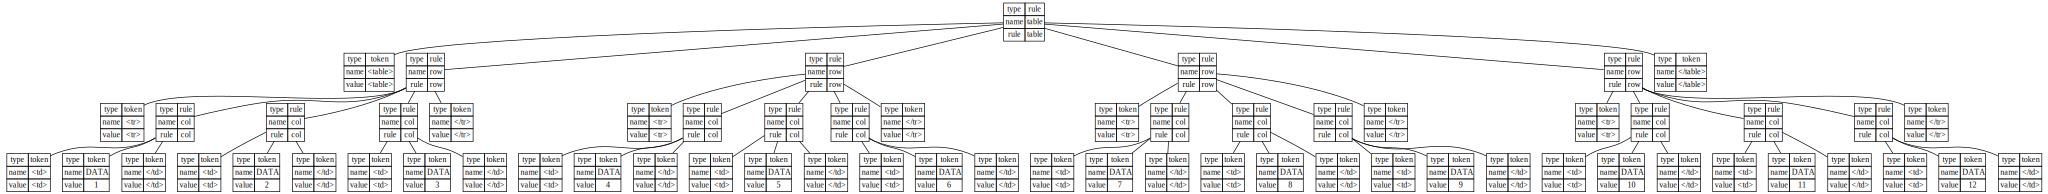

In [ ]:
parse_tree = HtmlTable.tree(table, 'table')
parse_tree

### Cosruzione dell'AST (sempre con *dispatch table*)

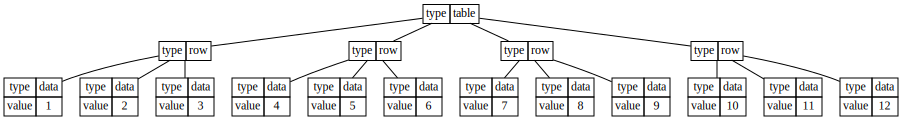

In [ ]:
def DATA(tree):
    return Tree({'type': 'data', 'value': int(tree.root['value'])})

def row(tree):
    cols = tree.children[1:-1] 
    return Tree({'type': 'row'}, [table_ast(tree.children[1]) for tree in cols])

def table(tree):
    rows = tree.children[1:-1] 
    return Tree({'type': 'table'}, [table_ast(tree) for tree in rows])
        
HTML_DISPATCH_TABLE = {
    'DATA': DATA,
    'row': row,
    'table': table,
}

def table_ast(tree):
    return HTML_DISPATCH_TABLE[tree.root['name']](tree)

ast = table_ast(parse_tree)
ast

### Dall'AST alla matrice

#### Usando una struttura dati esterna.

In [ ]:
STACK = Stack()

def ast2mat(tree):
    if tree.root['type'] == 'data':
        STACK.push(tree.root['value'])
    elif tree.root['type'] in ('row', 'table'):
        for child in tree.children: ast2mat(child)
        vals = [STACK.pop() for _ in range(len(tree.children))]
        STACK.push(vals[::-1])

ast2mat(ast)
mat = STACK.pop()
mat

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

Per gioco, si può persino tornare all'HTML, visto che una matrice Python (come stringa) è JSON!

In [ ]:
json = str(mat)
json

'[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]'

In [ ]:
HTML(ast2html(json_ast(JSON.tree(json, 'json'))))

1
2
3
4
5
6
7
8
9
10
11


#### Decorando i nodi

In [ ]:
# aggiungere il numero di riga (attributo eredidato)

def add_rownum(tree, n):
    if tree.root['type'] == 'table':
        for n, c in enumerate(tree.children): add_rownum(c, n)
        tree.root['numrows'] = 1 + n
    elif tree.root['type'] in 'row':
        tree.root['row'] = n
        for c in tree.children: add_rownum(c, n)
    elif tree.root['type'] in 'data':
        tree.root['row'] = n

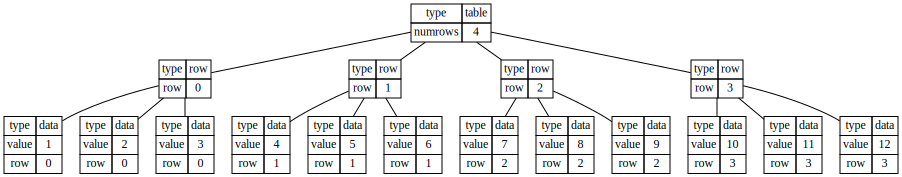

In [ ]:
ast = table_ast(parse_tree)        
add_rownum(ast, None)
ast

In [ ]:
# aggiungere il numero di colonna (attributo sintetizzato)
# Verificando anche che tutte le righe abbiano lo stesso numero di colonne

def add_colnum(tree, n):
    if tree.root['type'] == 'table':
        for c in tree.children: add_colnum(c, n)
        numcols = tree.children[0].root['numcols']
        for c in tree.children[1:]:
            if c.root['numcols'] != numcols:
                warn('la riga {} ha {} colonne, non {}'.format(child.root['row'], child.root['numcols'], numcols))
                return
        tree.root['numcols'] = numcols
    elif tree.root['type'] == 'row':
        for n, c in enumerate(tree.children): add_colnum(c, n)
        tree.root['numcols'] = 1 + n
    elif tree.root['type'] == 'data':
        tree.root['col'] = n

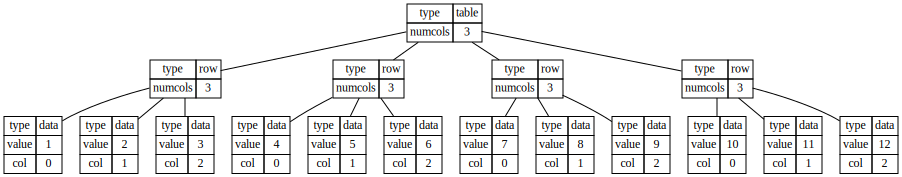

In [ ]:
ast = table_ast(parse_tree)                
add_colnum(ast, None)
ast

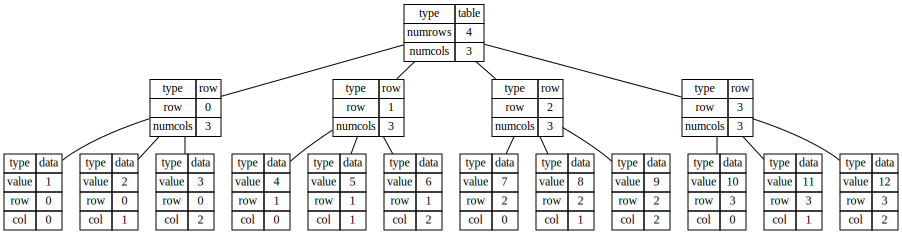

In [ ]:
# ora tutto assieme

ast = table_ast(parse_tree)     
add_rownum(ast, None)
add_colnum(ast, None)
ast

Avendo decorato i nodi, la costruzione della matrice è elementare

In [ ]:
numrows, numcols = ast.root['numrows'], ast.root['numcols']
mat = [[None for _ in range(numcols)] for _ in range(numrows)]
mat

[[None, None, None],
 [None, None, None],
 [None, None, None],
 [None, None, None]]

In [ ]:
# basta riempirla andando a caccia dei 'data'

def fill(tree):
    if tree.root['type'] == 'data':
        mat[tree.root['row']][tree.root['col']] = tree.root['value']
    else:
        for c in tree.children: fill(c)

In [ ]:
fill(ast)
mat

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

## <span style="color: red;">Esercizi per casa</span> 

* La grammatica del formato JSON ammette sia oggetti che array vuoti,
  ma le funzioni di trasformazione (vesro l'AST e quindi l'HTML) 
  non sono scritte per funzionare in tale caso. Riuscite a correggerle?
  
* Come osservato, la grammatica per la tabella HTML non consente di mettere una 
  tabella dentro l'altra. Modificate la grammatica (e le funzioni
  di trasformazione ed estrazione della matrice) in modo che
  consentano di avere una tabella, o un numero, in ogni cella; in
  questo modo estrarrete una "matrice" alcuni dei quali elementi
  saranno a loro volta matrici (di interi).